<a href="https://colab.research.google.com/github/nehashah2898/AIPI590/blob/main/Explainable_Techniques_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd

df=pd.read_csv('/content/netflix_titles.csv')


In [5]:
print(df.shape)
df.head()

(8807, 12)


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


In [6]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


In [13]:
# ================================
# 1. Setup
# ================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.inspection import partial_dependence

# Upload the dataset (or mount Google Drive and load)
# In Colab, run this cell and upload netflix_titles.csv when prompted:
from google.colab import files
uploaded = files.upload()

# Load dataset
df = pd.read_csv("netflix_titles.csv")
df.head()


Saving netflix_titles.csv to netflix_titles (1).csv


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


In [14]:
# ================================
# 2. Basic Preprocessing
# ================================
# Target: Movie=1, TV Show=0
df["target_is_movie"] = (df["type"] == "Movie").astype(int)

# Feature engineering
def parse_duration(row):
    val, typ = row["duration"], row["type"]
    if isinstance(val, str):
        if "min" in val:
            return int(val.split()[0])
        if "Season" in val:
            try:
                return int(val.split()[0]) * 60  # proxy conversion: 1 season ≈ 60 min
            except:
                return np.nan
    return np.nan

df["duration_numeric"] = df.apply(parse_duration, axis=1)
df["description_len"] = df["description"].fillna("").apply(len)
df["num_genres"] = df["listed_in"].fillna("").apply(lambda x: len(x.split(",")))
df["has_director"] = df["director"].apply(lambda x: 0 if pd.isna(x) else 1)

# Feature matrix
feature_cols = ["release_year", "duration_numeric", "description_len", "num_genres", "has_director"]
X = df[feature_cols].dropna()
y = df.loc[X.index, "target_is_movie"]

print("Dataset shape after preprocessing:", X.shape)


Dataset shape after preprocessing: (8804, 5)


In [15]:
 # ================================
# 3. Train/Test Split + Model
# ================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

clf = GradientBoostingClassifier(random_state=42)
clf.fit(X_train, y_train)

print("Model trained!")


Model trained!


In [16]:
# ================================
# 3. Train/Test Split + Model
# ================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

clf = GradientBoostingClassifier(random_state=42)
clf.fit(X_train, y_train)

print("Model trained!")


Model trained!


In [17]:
# ================================
# 4. PDP & ICE Plot Function
# ================================
def plot_pdp_ice(model, X, feature, n_ice_samples=50):
    feat_idx = list(X.columns).index(feature)
    pdp_res = partial_dependence(model, X, [feat_idx], grid_resolution=30, kind="average")
    values = pdp_res["values"][0]
    pdp = pdp_res["average"][0]

    # ICE
    rng = np.random.RandomState(42)
    sample_idx = rng.choice(np.arange(X.shape[0]), size=min(n_ice_samples, X.shape[0]), replace=False)
    X_base = X.iloc[sample_idx].copy()
    ice_curves = []
    for v in values:
        X_tmp = X_base.copy()
        X_tmp[feature] = v
        preds = model.predict_proba(X_tmp)[:, 1]
        ice_curves.append(preds)
    ice = np.vstack(ice_curves).T

    # Plot
    plt.figure(figsize=(7,5))
    for row in ice:
        plt.plot(values, row, alpha=0.2, color="gray")
    plt.plot(values, pdp, color="red", lw=2, label="PDP")
    plt.xlabel(feature)
    plt.ylabel("Predicted P(Movie)")
    plt.title(f"PDP & ICE for {feature}")
    plt.legend()
    plt.show()


In [1]:
from sklearn.inspection import PartialDependenceDisplay

def plot_pdp_ice(model, X, feature, n_ice_samples=50):
    feat_idx = list(X.columns).index(feature)

    # --- PDP ---
    pdp_res = partial_dependence(
        model, X, [feat_idx], grid_resolution=30, kind="average"
    )
    values = pdp_res.grid_values[0]     # fixed for new sklearn
    pdp = pdp_res.average[0]            # fixed for new sklearn

    # --- ICE ---
    rng = np.random.RandomState(42)
    sample_idx = rng.choice(
        np.arange(X.shape[0]), size=min(n_ice_samples, X.shape[0]), replace=False
    )
    X_base = X.iloc[sample_idx].copy()
    ice_curves = []
    for v in values:
        X_tmp = X_base.copy()
        X_tmp[feature] = v
        preds = model.predict_proba(X_tmp)[:, 1]
        ice_curves.append(preds)
    ice = np.vstack(ice_curves).T

    # --- Plot ---
    plt.figure(figsize=(7,5))
    for row in ice:
        plt.plot(values, row, alpha=0.2, color="gray")
    plt.plot(values, pdp, color="red", lw=2, label="PDP")
    plt.xlabel(feature)
    plt.ylabel("Predicted P(Movie)")
    plt.title(f"PDP & ICE for {feature}")
    plt.legend()
    plt.show()


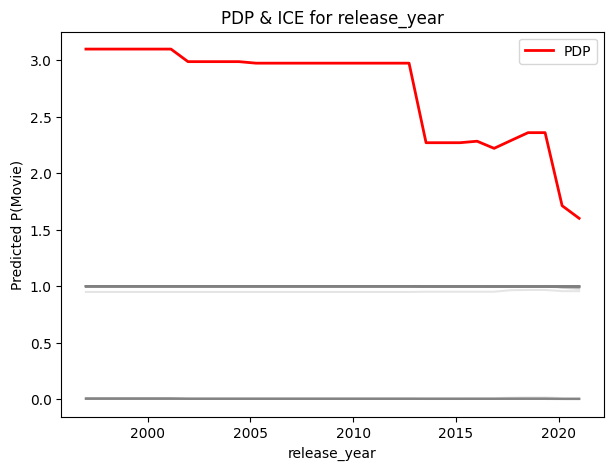

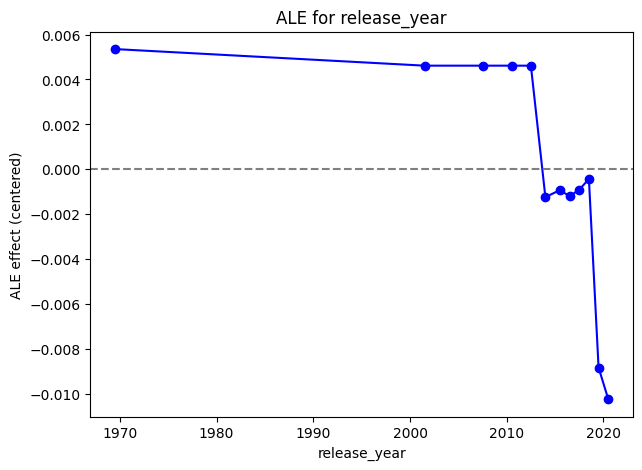

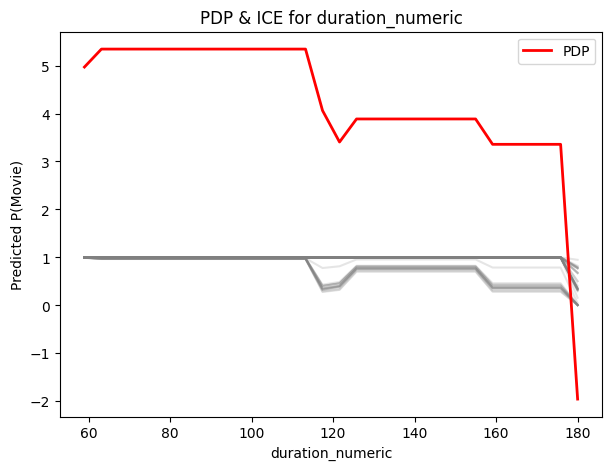

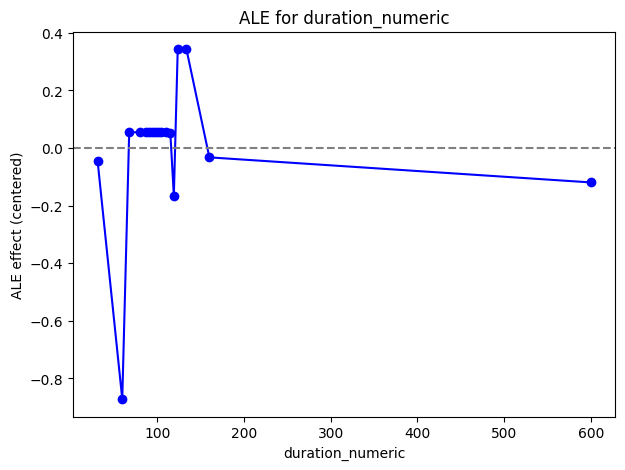

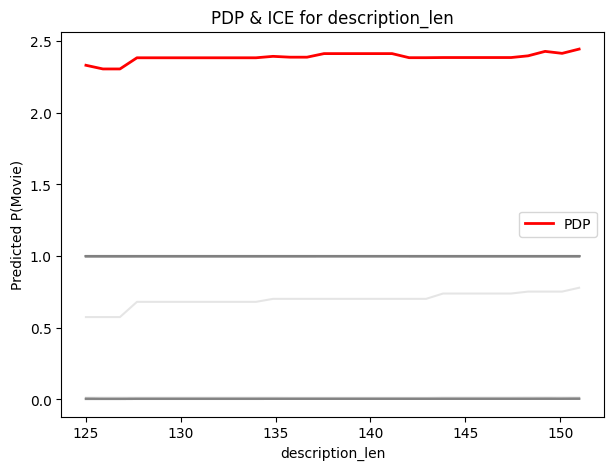

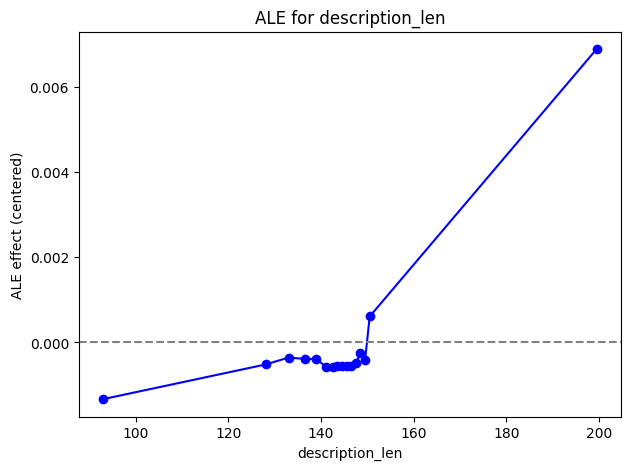

In [21]:
for f in ["release_year", "duration_numeric", "description_len"]:
    plot_pdp_ice(clf, X_train, f)
    plot_ale(clf, X_train, f)
